# Segmentation du Ventricule Gauche : 
3 approches differentes de segmentation du ventricule gauche (LV) à l'aide d'un UNet2D implémenté en PyTorch, d'un Active Contour (Snake) et d'un remplissage morphologique du myocarde


---

##  VERSIONS 

In [3]:
# ==== INFO VERSIONS ====
import sys
import os
import numpy      as np
import nibabel    as nib
import torch
import torchvision
import matplotlib as mpl
import tqdm
import scipy
import skimage

print(f"Python       : {sys.version.split()[0]}")
print(f"NumPy        : {np.__version__}")
print(f"NiBabel      : {nib.__version__}")
print(f"PyTorch      : {torch.__version__}")
print(f"TorchVision  : {torchvision.__version__}")
print(f"Matplotlib   : {mpl.__version__}")
print(f"tqdm         : {tqdm.__version__}")
print(f"SciPy        : {scipy.__version__}")
print(f"scikit-image : {skimage.__version__}")
# ========================


Python       : 3.11.12
NumPy        : 1.26.4
NiBabel      : 5.3.2
PyTorch      : 2.6.0
TorchVision  : 0.21.0
Matplotlib   : 3.10.0
tqdm         : 4.67.1
SciPy        : 1.15.2
scikit-image : 0.25.2


---

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.draw import polygon
from itertools import product



---

# Approche 1: Reconstruction du Ventricule Gauche par Réseau de Neurones Convolutifs (UNet2D)

## 1. Définition du Dataset 2 phases (ED & ES)
Chargement slice-by-slice, normalisation et resize pour la segmentation LV.

In [27]:

class VGSegDataset2Phases(Dataset):
    """
    Cette classe charge les images IRM (ED et ES) et leurs masques LV 
    en vue d'un traitement slice par slice, puis effectue une normalisation 
    et un redimensionnement avant de renvoyer des tenseurs prêts à l'entraînement.
    Attributs :
        - samples : liste de tuples (image, masque) pour chaque coupe
        - img_size : taille de l'image après redimensionnement
    Méthodes :
        - __init__ : constructeur qui charge les images et masques
        - __len__ : retourne le nombre total de coupes
        - __getitem__ : retourne une coupe et son masque à partir de l'index  

    """
    def __init__(self, base_path, split=None, img_size=(128,128)):
        """
        split : str ou None
            - 'ED'  pour ne charger que la phase ED
            - 'ES'  pour ne charger que la phase ES
            - None  pour charger ED et ES
        """
        self.samples = []
        self.img_size = img_size
        self.split = split
        
        # Détermine les phases à charger
        if split is None:
            phases = ['ED', 'ES']
        else:
            phases = [split]

        for pid in sorted(os.listdir(base_path)):
            subj = os.path.join(base_path, pid)
            if not os.path.isdir(subj):
                continue

            # Récupération des fichiers selon le(s) phase(s) 
            for phase in phases:
                img_path = os.path.join(subj, f"{pid}_{phase}.nii")
                seg_path = os.path.join(subj, f"{pid}_{phase}_seg.nii")
                if not os.path.exists(img_path) or not os.path.exists(seg_path):
                    continue

                # Lecture et stockage coupe par coupe
                vol = nib.load(img_path).get_fdata()
                seg = nib.load(seg_path).get_fdata().astype(np.uint8)
                for z in range(vol.shape[2]):
                    self.samples.append((vol[:,:,z], (seg[:,:,z] == 3).astype(np.uint8)))

    def __len__(self):
        # Retourne le nombre total de coupes
        return len(self.samples)

    def __getitem__(self, idx):
        # Lecture d'une coupe et de son masque
        img2d, mask2d = self.samples[idx]

        # Normalisation en [0,1]
        img = (img2d - img2d.min()) / (img2d.max() - img2d.min() + 1e-8)

        # Conversion en tenseurs PyTorch 
        img = torch.from_numpy(img).unsqueeze(0).float()
        mask = torch.from_numpy(mask2d).unsqueeze(0).float()

        # Resize : bilinéaire pour l’image, nearest pour le masque
        img = TF.resize(img, self.img_size)
        mask = TF.resize(mask, self.img_size, interpolation=TF.InterpolationMode.NEAREST)

        # Retour du couple (image, masque) prêt à l'entraînement
        return img, mask

Nombre d'échantillons : 1902
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


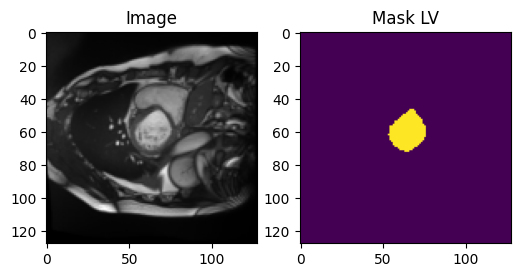

In [21]:
# Petit check
ds = VGSegDataset2Phases("data/Train", img_size=(128,128))
print("Nombre d'échantillons :", len(ds))
img, mask = ds[1]
print(img.shape, mask.shape)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img.squeeze(), cmap='gray'); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(mask.squeeze());        plt.title("Mask LV")
plt.show()


## 2. Architecture du Modèle UNet2D 

Ici, on définit deux blocs :  
- `DoubleConv` : deux convolutions 3×3 + BatchNorm + ReLU  
- `UNet2D` : encodeur / bottleneck / décodeur avec skip-connections


In [ ]:
class DoubleConv(nn.Module):
    """
    Bloc convolutif double : (Conv → BN → ReLU) x 2.

    Parameters
    ----------
    in_ch : int
        Nombre de canaux en entrée.
    out_ch : int
        Nombre de canaux en sortie.

    Attributes
    ----------
    double_conv : nn.Sequential
        Séquence de deux blocs Conv2d–BatchNorm2d–ReLU.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet2D(nn.Module):
    """
    UNet 2D générique avec skip-connections.

    Parameters
    ----------
    in_ch : int, default=1
        Canaux d’entrée.
    out_ch : int, default=1
        Canaux de sortie.
    features : list of int, default=[64,128,256,512]
        Nombre de filtres pour chaque niveau de l’encodeur.

    Attributes
    ----------
    encoder : ModuleList
        Blocs `DoubleConv` pour descendre la résolution.
    pool : MaxPool2d
        Pooling 2x2 entre chaque étage encodeur.
    bottleneck : DoubleConv
        Bloc central à la résolution la plus faible.
    up_transpose : ModuleList
        Convolutions transposées pour remonter la résolution.
    decoder : ModuleList
        Blocs `DoubleConv` après concaténation des skip connections.
    final_conv : Conv2d
        Convolution 1x1 pour ramener au nombre de canaux de sortie.
    """
    def __init__(self, in_ch=1, out_ch=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Phase d'encodage : on accumule les features tout en réduisant la dimension
        for f in features:
            self.encoder.append(DoubleConv(in_ch, f))
            in_ch = f
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # Phase de décodage : on reconstruit la résolution
        self.up_transpose = nn.ModuleList()
        self.decoder = nn.ModuleList()
        in_ch = features[-1]*2
        for f in reversed(features):
            self.up_transpose.append(nn.ConvTranspose2d(in_ch, f, kernel_size=2, stride=2))
            # Après concaténation skip (f + f) → f
            self.decoder.append(DoubleConv(f*2, f))
            in_ch = f
        # Final 1x1 conv
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        
        # Parcours de l'encodeur et stockage des sorties intermédiaires
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # On inverse les connexions résiduelles pour parcourir le réseau en sens inverse
        skip_connections = skip_connections[::-1]

        # Parcours du décodeur: on concatène la sortie upsamplée aux features précédentes
        for idx in range(len(self.up_transpose)):
            x = self.up_transpose[idx](x)
            skip = skip_connections[idx]
            if x.shape != skip.shape:  
                x = TF.resize(x, skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[idx](x)

        return self.final_conv(x)

## 4. Fonction de Perte et Métrique Dice

In [ ]:
def dice_loss(pred, target, smooth=1.0):
    """
    Dice Loss entre prédiction brute (logits) et vérité-terrain binaire.

    Parameters
    ----------
    pred : torch.Tensor
        Logits de sortie du réseau, forme (B, 1, H, W) ou aplati.
    target : torch.Tensor
        Masque binaire (0 ou 1), même forme que pred après sigmoid.
    smooth : float, default=1.0
        Terme d’adoucissement pour éviter la division par zéro.

    Returns
    -------
    torch.Tensor
        Valeur scalaire de la Dice Loss (entre 0 et 1).
    """
    # Applique la sigmoïde pour obtenir des probabilités
    prob = torch.sigmoid(pred)
    # Aplatir tous les pixels pour le calcul global
    prob = prob.view(-1)
    target = target.view(-1).float()

    # Calcul de l’intersection
    inter = (prob * target).sum()

    # Formule de la Dice Loss lissée
    dice = (2 * inter + smooth) / (prob.sum() + target.sum() + smooth)
    return 1.0 - dice

def dice_coefficient(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return (2.*inter + eps)/(pred.sum() + target.sum() + eps)

## 5. Chargement des Données et DataLoaders

In [8]:
base_path = 'data/Train'
batch_size = 8
img_size = (128, 128)
dataset = VGSegDataset2Phases(base_path, img_size=img_size)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device (GPU si disponible)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

Device utilisé : mps


## 6. Boucle d'Entraînement

In [11]:
# Initialisation
model = UNet2D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

total_start_time = time.time() 
# Entraînement
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_loss = 0.0
    loop = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs}")
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()                   # réinitialise les gradients
        outputs = model(imgs)                   # forward pass
        loss    = dice_loss(outputs, masks)     # calcul de la loss
        loss.backward()                         # backprop
        optimizer.step()                        # mise à jour des poids

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())      # affichage de la loss instantanée
    print(f"→ Epoch {epoch} – Loss moyenne : {epoch_loss/len(loader):.4f}")


total_end_time = time.time() 
total_duration = total_end_time - total_start_time
print(f'\n Temps total d\'entraînement : {total_duration/60:.2f} minutes ({total_duration:.2f} sec)')

# Sauvegarde du modèle
model_path = 'unet2d_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Modèle sauvegardé sous {model_path}")

Epoch 1/20: 100%|██████████| 238/238 [01:07<00:00,  3.54it/s, loss=0.0984]


→ Epoch 1 – Loss moyenne : 0.5298


Epoch 2/20: 100%|██████████| 238/238 [01:07<00:00,  3.52it/s, loss=0.0533]


→ Epoch 2 – Loss moyenne : 0.1164


Epoch 3/20: 100%|██████████| 238/238 [01:07<00:00,  3.53it/s, loss=0.0556]


→ Epoch 3 – Loss moyenne : 0.0918


Epoch 4/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0483]


→ Epoch 4 – Loss moyenne : 0.0785


Epoch 5/20: 100%|██████████| 238/238 [01:06<00:00,  3.60it/s, loss=0.0535]


→ Epoch 5 – Loss moyenne : 0.0783


Epoch 6/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0622]


→ Epoch 6 – Loss moyenne : 0.0649


Epoch 7/20: 100%|██████████| 238/238 [01:07<00:00,  3.54it/s, loss=0.0577]


→ Epoch 7 – Loss moyenne : 0.0577


Epoch 8/20: 100%|██████████| 238/238 [01:07<00:00,  3.51it/s, loss=0.0461]


→ Epoch 8 – Loss moyenne : 0.0569


Epoch 9/20: 100%|██████████| 238/238 [01:07<00:00,  3.55it/s, loss=0.0546]


→ Epoch 9 – Loss moyenne : 0.0545


Epoch 10/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.038] 


→ Epoch 10 – Loss moyenne : 0.0539


Epoch 11/20: 100%|██████████| 238/238 [01:07<00:00,  3.55it/s, loss=0.0311]


→ Epoch 11 – Loss moyenne : 0.0547


Epoch 12/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0393]


→ Epoch 12 – Loss moyenne : 0.0515


Epoch 13/20: 100%|██████████| 238/238 [01:06<00:00,  3.59it/s, loss=0.0526]


→ Epoch 13 – Loss moyenne : 0.0522


Epoch 14/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0388]


→ Epoch 14 – Loss moyenne : 0.0513


Epoch 15/20: 100%|██████████| 238/238 [01:06<00:00,  3.59it/s, loss=0.0608]


→ Epoch 15 – Loss moyenne : 0.0473


Epoch 16/20: 100%|██████████| 238/238 [01:07<00:00,  3.54it/s, loss=0.219] 


→ Epoch 16 – Loss moyenne : 0.0485


Epoch 17/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0513]


→ Epoch 17 – Loss moyenne : 0.0600


Epoch 18/20: 100%|██████████| 238/238 [01:06<00:00,  3.57it/s, loss=0.0475]


→ Epoch 18 – Loss moyenne : 0.0481


Epoch 19/20: 100%|██████████| 238/238 [01:06<00:00,  3.56it/s, loss=0.0335]


→ Epoch 19 – Loss moyenne : 0.0449


Epoch 20/20: 100%|██████████| 238/238 [01:06<00:00,  3.58it/s, loss=0.0477]

→ Epoch 20 – Loss moyenne : 0.0441

 Temps total d'entraînement : 22.27 minutes (1336.23 sec)
Modèle sauvegardé sous unet2d_model.pth


## 7. Évaluation et Dice Moyen

In [ ]:
# Instanciation des datasets
ds_ED = VGSegDataset2Phases(base_path='data/Train', split='ED', img_size=(128,128))
ds_ES = VGSegDataset2Phases(base_path='data/Train', split='ES', img_size=(128,128))


def evaluate(model, dataset, device, threshold=0.5):
    """
    Calcule le Dice moyen entre prédiction et vérité-terrain pour un dataset.

    Parameters
    ----------
    model : nn.Module
        Modèle PyTorch déjà chargé en mode evaluation.
    dataset : VGSegDataset
        Dataset fournissant (img, mask) prétraités.
    device : torch.device
        Emplacement pour le calcul ....
    threshold : float, default=0.5
        Seuil appliqué aux probabilités pour obtenir un masque binaire.

    Returns
    -------
    float
        Dice coefficient moyen sur toutes les slices du dataset.
    """
    model.eval()  # on passe en mode évaluation 
    total_dice = 0.0

    with torch.no_grad():
        for img, mask in tqdm(dataset, desc=f"Éval {dataset.split}"):
            # img : (1, H, W), mask : (1, H, W)
            img   = img.to(device)
            mask  = mask.to(device).view(-1)  # aplati pour le dice_coefficient

            # Prédiction
            logits = model(img.unsqueeze(0))               # forme (1,1,H,W)
            prob   = torch.sigmoid(logits).view(-1)        # aplati
            pred   = (prob > threshold).float()            # masque binaire

            # Calcul du Dice coefficient
            total_dice += dice_coefficient(pred, mask).item()

    # Moyenne sur le nombre d’échantillons
    return total_dice / len(dataset)


# On évalue pour chaque phase
dice_ED = evaluate(model, ds_ED, device)
dice_ES = evaluate(model, ds_ES, device)

print(f"→ Dice moyen ED : {dice_ED:.4f}")
print(f"→ Dice moyen ES : {dice_ES:.4f}")


Éval ES: 100%|██████████| 951/951 [00:10<00:00, 94.30it/s]

→ Dice moyen ED : 0.9386
→ Dice moyen ES : 0.8966


## 8. Visualisation des Résultats

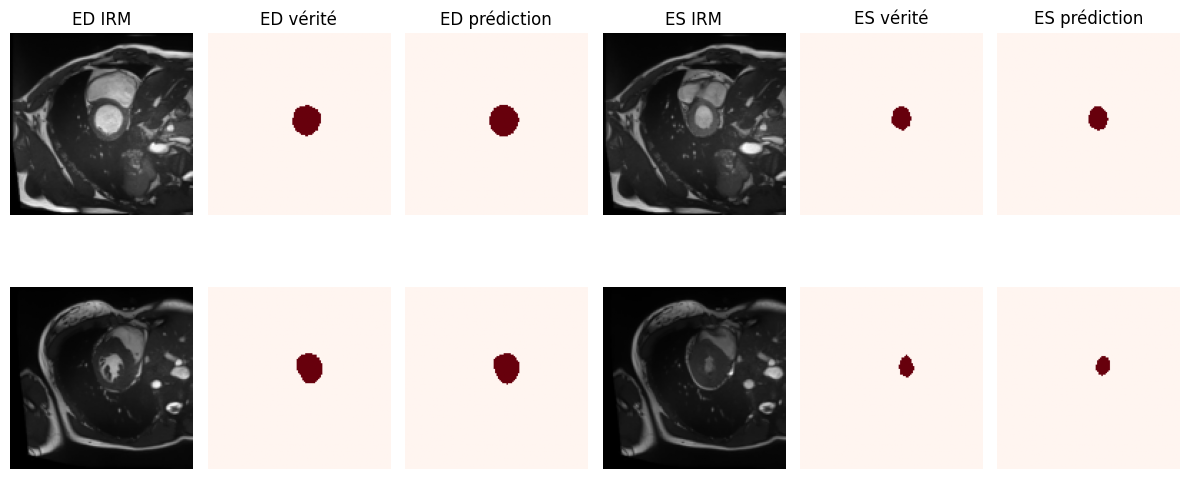

In [31]:
idxs = random.sample(range(min(len(ds_ED), len(ds_ES))), 2)

fig, axes = plt.subplots(2, 6, figsize=(12, 6))
col_titles = ['ED IRM', 'ED vérité', 'ED prédiction', 'ES IRM', 'ES vérité', 'ES prédiction']
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title)

for i, idx in enumerate(idxs):
    img_ED, mask_ED = ds_ED[idx]
    pred_ED = (torch.sigmoid(model(img_ED.unsqueeze(0).to(device))) > 0.5).float().cpu().squeeze().numpy()
    img_ES, mask_ES = ds_ES[idx]
    pred_ES = (torch.sigmoid(model(img_ES.unsqueeze(0).to(device))) > 0.5).float().cpu().squeeze().numpy()

    axes[i, 0].imshow(img_ED.squeeze(), cmap='gray')
    axes[i, 1].imshow(mask_ED.squeeze(), cmap='Reds')
    axes[i, 2].imshow(pred_ED,         cmap='Reds')
    axes[i, 3].imshow(img_ES.squeeze(), cmap='gray')
    axes[i, 4].imshow(mask_ES.squeeze(), cmap='Reds')
    axes[i, 5].imshow(pred_ES,         cmap='Reds')

    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()


---
# Approche 2: Reconstruction du Ventricule Gauche par Active Contour (Snake)

On exploite le masque myocardique (label 2) pour initialiser un snake, qu’on fait évoluer sur l’image lissée afin de reconstituer le volume LV (label 3).

In [3]:

def load_nifti(path):
    nii = nib.load(path)
    return nii.get_fdata(), nii.affine

def initial_circle(center, radius, num_points=100):
    s = np.linspace(0, 2*np.pi, num_points)
    r = center[0] + radius * np.sin(s)
    c = center[1] + radius * np.cos(s)
    return np.vstack((r, c)).T

def segment_lv_active_contour(slice_2d, init_contour, alpha, beta, gamma, max_iter=300):
    slice_smooth = gaussian(slice_2d, sigma=3)
    snake = active_contour(
        slice_smooth, init_contour,
        alpha=alpha, beta=beta, gamma=gamma,
        max_num_iter=max_iter, convergence=1e-4
    )
    return snake

def snake_to_mask(snake, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    rr, cc = polygon(snake[:,0], snake[:,1], shape=shape)
    mask[rr,cc] = 3
    return mask



def reconstruct_lv_with_snake_on_myo(seg_volume,
                                     alpha=0.1, beta=1.0, gamma=0.05,
                                     sigma=1.0, max_iter=200):
    """
    Applique le snake sur la coupe binaire du myocarde (label 2) pour reconstruire le LV (label 3).
    calcule le centre et le rayon initial à partir du masque myo
    """
    H, W, D = seg_volume.shape
    recon = np.zeros((H, W, D), dtype=np.uint8)

    for z in range(D):
        myo = (seg_volume[:, :, z] == 2)
        if myo.sum() == 0:
            continue

        # centre de masse du myocarde
        cy, cx = ndimage.center_of_mass(myo)
        # rayon équivalent (aire/pi) * facteur de sécurité
        R = np.sqrt(myo.sum() / np.pi) * 1.2

        # contour initial
        init = initial_circle((cy, cx), R)

        # on segmente sur l'image binaire lissée
        img_smooth = gaussian(myo.astype(float), sigma=sigma)
        snake = active_contour(
            img_smooth, init,
            alpha=alpha, beta=beta, gamma=gamma,
            max_num_iter=max_iter, convergence=1e-3
        )

        # conversion en masque LV (3)
        mask_lv = snake_to_mask(snake, (H, W))
        recon[:, :, z] = mask_lv

    return recon


def fuse_reconstruction(seg_no3, recon_vol):
    fused = seg_no3.copy()
    mask_lv = (seg_no3 == 0) & (recon_vol == 3)
    fused[mask_lv] = 3
    return fused

def dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2.0 * intersection.sum() / (mask1.sum() + mask2.sum() + 1e-8)

#### Recherche aléatoire d’hyper-paramètres

- **20 patients** échantillonnés pour l’entraînement  
- **30 combinaisons** tirées au hasard dans la grille complète  
- On optimise le Dice moyen (ED & ES) et on conserve la meilleure configuration.


In [ ]:

# Grilles de recherche
alpha_list   = [0.01, 0.1, 0.5]
beta_list    = [0.5, 1.0, 2.0]
gamma_list   = [0.01, 0.05, 0.1]
sigma_list   = [0.5, 1.0, 2.0]
max_iter_list= [100, 200, 300]

# Sélection de 20 patients aléatoires
all_subject_ids = [f"{i:03d}" for i in range(1, 101)]
random.seed(42)  # pour reproductibilité
subject_ids = random.sample(all_subject_ids, 20)

# Sélection de 30 combinaisons aléatoires dans la grille totale
grid = list(product(alpha_list, beta_list, gamma_list, sigma_list, max_iter_list))
grid_subset = random.sample(grid, 30)



In [5]:
best = {"score": -1}
# Boucle sur les 30 combinaisons sélectionnées
start_time = time.time()

for alpha, beta, gamma, sigma, max_iter in tqdm(grid_subset, desc="Recherche des meilleurs paramètres", total=len(grid_subset)):
    t0 = time.time()
    dice_ED, dice_ES = [], []
    # Pour chaque phase et chaque patient, on reconstruit et on mesure le Dice
    for phase, dice_list in [("ED", dice_ED), ("ES", dice_ES)]:
        for sid in subject_ids:
            img_path = os.path.join(data_dir, sid, f"{sid}_{phase}.nii")
            seg_path = os.path.join(data_dir, sid, f"{sid}_{phase}_seg.nii")
            if not os.path.exists(img_path) or not os.path.exists(seg_path):
                continue

            _, _ = load_nifti(img_path)
            seg_gt = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg_no3 = np.where(seg_gt == 3, 0, seg_gt)

            recon_lv = reconstruct_lv_with_snake_on_myo(seg_gt, alpha, beta, gamma, sigma, max_iter)
            fused = fuse_reconstruction(seg_no3, recon_lv)

            dice_list.append(dice_coefficient(seg_gt == 3, fused == 3))
    # Moyennes et score global
    mean_ED, mean_ES = np.mean(dice_ED), np.mean(dice_ES)
    score = 0.5 * (mean_ED + mean_ES)
    t1 = time.time()

    print(f"α={alpha}, β={beta}, γ={gamma}, σ={sigma}, it={max_iter} "
          f"→ ED={mean_ED:.3f}, ES={mean_ES:.3f}, avg={score:.3f} | durée = {t1 - t0:.1f} sec")

    if score > best["score"]:
        best["score"] = score
        best["params"] = (alpha, beta, gamma, sigma, max_iter, mean_ED, mean_ES)

# Temps total
total_time = time.time() - start_time
print(f"\nTemps total de recherche : {total_time / 60:.1f} minutes")


Recherche des meilleurs paramètres:   3%|▎         | 1/30 [00:39<19:09, 39.64s/it]

α=0.01, β=1.0, γ=0.1, σ=1.0, it=300 → ED=0.985, ES=0.972, avg=0.978 | durée = 39.6 sec


Recherche des meilleurs paramètres:   7%|▋         | 2/30 [00:51<10:56, 23.43s/it]

α=0.5, β=0.5, γ=0.1, σ=1.0, it=100 → ED=0.852, ES=0.922, avg=0.887 | durée = 12.1 sec


Recherche des meilleurs paramètres:  10%|█         | 3/30 [01:10<09:38, 21.42s/it]

α=0.5, β=0.5, γ=0.01, σ=1.0, it=200 → ED=0.805, ES=0.887, avg=0.846 | durée = 19.0 sec


Recherche des meilleurs paramètres:  13%|█▎        | 4/30 [01:29<08:50, 20.40s/it]

α=0.5, β=0.5, γ=0.05, σ=2.0, it=300 → ED=0.692, ES=0.860, avg=0.776 | durée = 18.8 sec


Recherche des meilleurs paramètres:  17%|█▋        | 5/30 [01:48<08:14, 19.78s/it]

α=0.1, β=2.0, γ=0.01, σ=1.0, it=200 → ED=0.937, ES=0.958, avg=0.948 | durée = 18.7 sec


Recherche des meilleurs paramètres:  20%|██        | 6/30 [02:15<08:51, 22.17s/it]

α=0.1, β=0.5, γ=0.1, σ=2.0, it=300 → ED=0.967, ES=0.989, avg=0.978 | durée = 26.8 sec


Recherche des meilleurs paramètres:  23%|██▎       | 7/30 [02:43<09:18, 24.27s/it]

α=0.01, β=2.0, γ=0.01, σ=0.5, it=300 → ED=0.957, ES=0.955, avg=0.956 | durée = 28.6 sec


Recherche des meilleurs paramètres:  27%|██▋       | 8/30 [02:58<07:46, 21.20s/it]

α=0.1, β=1.0, γ=0.01, σ=2.0, it=100 → ED=0.957, ES=0.962, avg=0.959 | durée = 14.6 sec


Recherche des meilleurs paramètres:  30%|███       | 9/30 [03:10<06:27, 18.45s/it]

α=0.1, β=2.0, γ=0.05, σ=2.0, it=100 → ED=0.967, ES=0.989, avg=0.978 | durée = 12.4 sec


Recherche des meilleurs paramètres:  33%|███▎      | 10/30 [03:40<07:18, 21.94s/it]

α=0.01, β=2.0, γ=0.05, σ=2.0, it=300 → ED=0.977, ES=0.990, avg=0.983 | durée = 29.7 sec


Recherche des meilleurs paramètres:  37%|███▋      | 11/30 [03:53<06:02, 19.09s/it]

α=0.5, β=1.0, γ=0.1, σ=0.5, it=100 → ED=0.844, ES=0.916, avg=0.880 | durée = 12.6 sec


Recherche des meilleurs paramètres:  40%|████      | 12/30 [04:04<05:04, 16.90s/it]

α=0.5, β=2.0, γ=0.01, σ=2.0, it=100 → ED=0.689, ES=0.848, avg=0.768 | durée = 11.9 sec


Recherche des meilleurs paramètres:  43%|████▎     | 13/30 [04:25<05:06, 18.01s/it]

α=0.01, β=0.5, γ=0.01, σ=0.5, it=200 → ED=0.956, ES=0.957, avg=0.957 | durée = 20.6 sec


Recherche des meilleurs paramètres:  47%|████▋     | 14/30 [04:54<05:40, 21.29s/it]

α=0.5, β=1.0, γ=0.01, σ=1.0, it=300 → ED=0.794, ES=0.886, avg=0.840 | durée = 28.9 sec


Recherche des meilleurs paramètres:  50%|█████     | 15/30 [05:15<05:17, 21.17s/it]

α=0.5, β=1.0, γ=0.05, σ=2.0, it=300 → ED=0.692, ES=0.860, avg=0.776 | durée = 20.9 sec


Recherche des meilleurs paramètres:  53%|█████▎    | 16/30 [05:35<04:50, 20.78s/it]

α=0.01, β=1.0, γ=0.05, σ=1.0, it=200 → ED=0.980, ES=0.964, avg=0.972 | durée = 19.9 sec


Recherche des meilleurs paramètres:  57%|█████▋    | 17/30 [05:54<04:24, 20.32s/it]

α=0.5, β=0.5, γ=0.05, σ=2.0, it=200 → ED=0.692, ES=0.860, avg=0.776 | durée = 19.2 sec


Recherche des meilleurs paramètres:  60%|██████    | 18/30 [06:06<03:32, 17.70s/it]

α=0.1, β=1.0, γ=0.01, σ=0.5, it=100 → ED=0.893, ES=0.943, avg=0.918 | durée = 11.6 sec


Recherche des meilleurs paramètres:  63%|██████▎   | 19/30 [06:17<02:54, 15.82s/it]

α=0.1, β=0.5, γ=0.01, σ=2.0, it=100 → ED=0.957, ES=0.963, avg=0.960 | durée = 11.4 sec


Recherche des meilleurs paramètres:  67%|██████▋   | 20/30 [06:36<02:47, 16.77s/it]

α=0.5, β=2.0, γ=0.05, σ=2.0, it=300 → ED=0.692, ES=0.856, avg=0.774 | durée = 19.0 sec


Recherche des meilleurs paramètres:  70%|███████   | 21/30 [06:47<02:14, 14.90s/it]

α=0.01, β=1.0, γ=0.05, σ=1.0, it=100 → ED=0.980, ES=0.964, avg=0.972 | durée = 10.6 sec


Recherche des meilleurs paramètres:  73%|███████▎  | 22/30 [07:07<02:11, 16.44s/it]

α=0.01, β=2.0, γ=0.01, σ=0.5, it=200 → ED=0.957, ES=0.954, avg=0.956 | durée = 20.0 sec


Recherche des meilleurs paramètres:  77%|███████▋  | 23/30 [07:17<01:41, 14.56s/it]

α=0.5, β=1.0, γ=0.01, σ=2.0, it=100 → ED=0.690, ES=0.848, avg=0.769 | durée = 10.2 sec


Recherche des meilleurs paramètres:  80%|████████  | 24/30 [07:44<01:50, 18.46s/it]

α=0.1, β=0.5, γ=0.01, σ=1.0, it=300 → ED=0.937, ES=0.958, avg=0.947 | durée = 27.5 sec


Recherche des meilleurs paramètres:  83%|████████▎ | 25/30 [08:12<01:45, 21.18s/it]

α=0.01, β=0.5, γ=0.1, σ=2.0, it=300 → ED=0.977, ES=0.990, avg=0.984 | durée = 27.5 sec


Recherche des meilleurs paramètres:  87%|████████▋ | 26/30 [08:41<01:34, 23.62s/it]

α=0.01, β=0.5, γ=0.1, σ=1.0, it=300 → ED=0.984, ES=0.972, avg=0.978 | durée = 29.3 sec


Recherche des meilleurs paramètres:  90%|█████████ | 27/30 [09:01<01:07, 22.44s/it]

α=0.1, β=0.5, γ=0.05, σ=2.0, it=200 → ED=0.964, ES=0.988, avg=0.976 | durée = 19.7 sec


Recherche des meilleurs paramètres:  93%|█████████▎| 28/30 [09:11<00:37, 18.90s/it]

α=0.01, β=0.5, γ=0.1, σ=2.0, it=100 → ED=0.977, ES=0.990, avg=0.984 | durée = 10.6 sec


Recherche des meilleurs paramètres:  97%|█████████▋| 29/30 [09:30<00:18, 18.88s/it]

α=0.1, β=0.5, γ=0.05, σ=0.5, it=200 → ED=0.929, ES=0.959, avg=0.944 | durée = 18.8 sec


Recherche des meilleurs paramètres: 100%|██████████| 30/30 [09:50<00:00, 19.68s/it]

α=0.1, β=0.5, γ=0.01, σ=2.0, it=200 → ED=0.957, ES=0.963, avg=0.960 | durée = 19.7 sec

Temps total de recherche : 9.8 minutes


In [6]:
# Affichage du meilleur résultat
#alpha_opt, beta_opt, gamma_opt, sigma_opt, it_opt, ed_opt, es_opt = best["params"]
alpha_opt, beta_opt, gamma_opt, sigma_opt = 0.01, 0.5, 0.1, 2.0
it_opt, ed_opt, es_opt = 100, 0.977, 0.990
print("\nMeilleur combo :")
print(f"  α={alpha_opt}, β={beta_opt}, γ={gamma_opt}, σ={sigma_opt}, it={it_opt}")
print(f"  → Dice ED = {ed_opt:.3f}, ES = {es_opt:.3f}, Moyenne = {best['score']:.3f}")


Meilleur combo :
  α=0.01, β=0.5, γ=0.1, σ=2.0, it=100
  → Dice ED = 0.977, ES = 0.990, Moyenne = 0.984


> **Résultat**  
> - Meilleurs paramètres trouvés : α=0.01, β=0.5, γ=0.1, σ=2.0, it=100
> - Dice moyen Dice ED = 0.977, ES = 0.990, (score global = 0.984)  
> - Temps total : 9.8 minutes




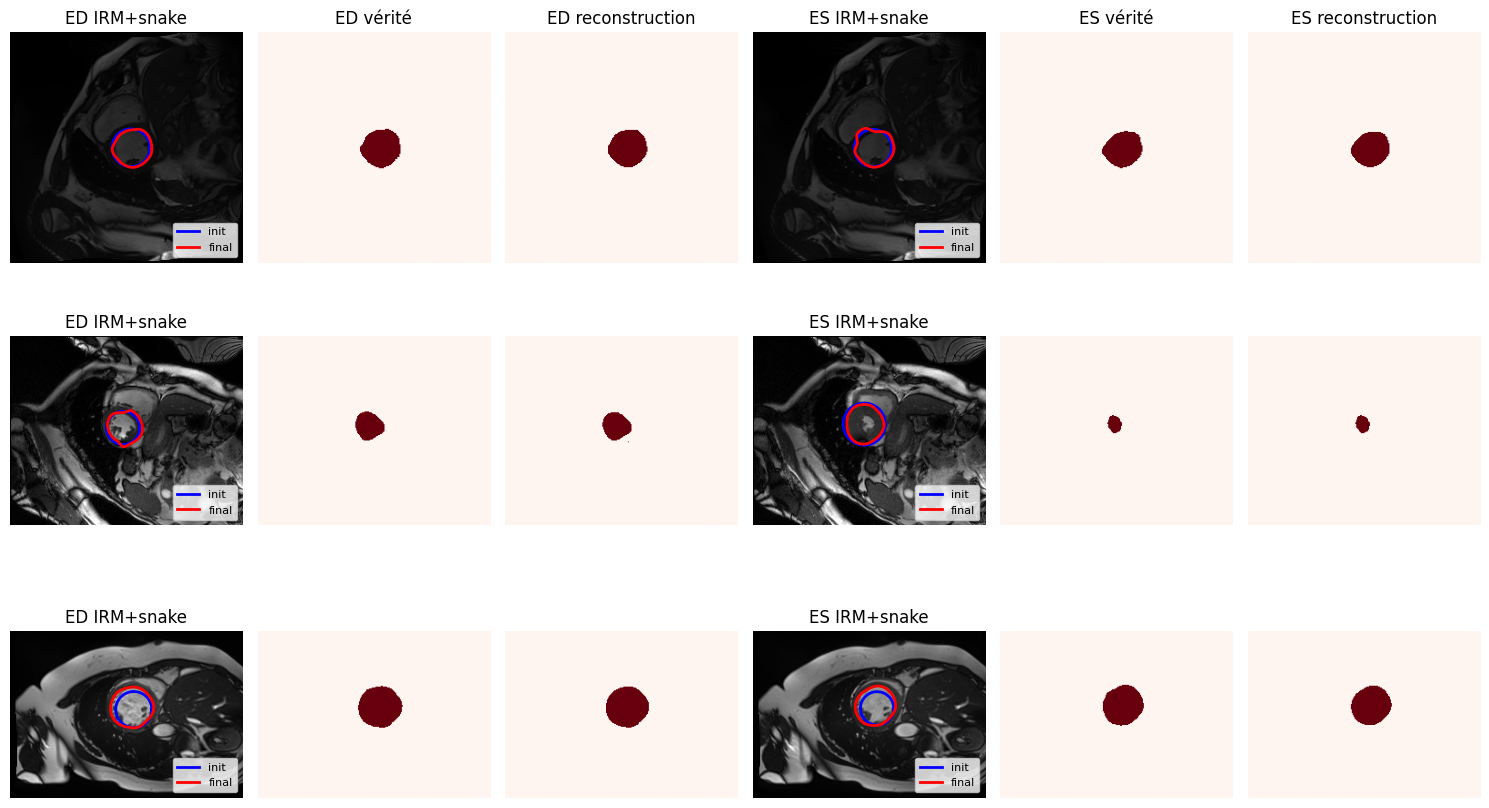

In [51]:
# Affichage du meilleur résultat
#alpha_opt, beta_opt, gamma_opt, sigma_opt, it_opt, ed_opt, es_opt = best["params"]
alpha_opt, beta_opt, gamma_opt, sigma_opt = 0.01, 0.5, 0.1, 2.0
it_opt, ed_opt, es_opt = 100, 0.977, 0.990

phases = ["ED", "ES"]
random.seed(123)
sample_ids = random.sample(all_subject_ids, 3)

fig, axes = plt.subplots(len(sample_ids), 6, figsize=(15, 9))
col_titles = ['ED IRM+snake', 'ED vérité', 'ED reconstruction', 'ES IRM+snake', 'ES vérité', 'ES reconstruction']
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title)

for i, sid in enumerate(sample_ids):
    for j, phase in enumerate(phases):
        img_vol, _ = load_nifti(f"{data_dir}/{sid}/{sid}_{phase}.nii")
        seg_gt = nib.load(f"{data_dir}/{sid}/{sid}_{phase}_seg.nii").get_fdata().astype(np.uint8)

        # reconstruction complète
        recon_lv = reconstruct_lv_with_snake_on_myo(
            seg_gt,
            alpha=alpha_opt, beta=beta_opt,
            gamma=gamma_opt, sigma=sigma_opt,
            max_iter=it_opt
        )
        seg_no3 = np.where(seg_gt == 3, 0, seg_gt)
        fused = fuse_reconstruction(seg_no3, recon_lv)

        H, W, D = img_vol.shape
        slice_idx = D // 3
        myo_slice = (seg_gt[:, :, slice_idx] == 2).astype(float)

        cy, cx = ndimage.center_of_mass(myo_slice)
        if np.isnan(cy) or np.isnan(cx): cy, cx = H//2, W//2
        R = np.sqrt(myo_slice.sum() / np.pi) * 1.2
        init_snake = initial_circle((cy, cx), R)

        img_smooth = gaussian(myo_slice, sigma=sigma_opt)
        final_snake = active_contour(
            img_smooth, init_snake,
            alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt,
            max_num_iter=it_opt, convergence=1e-3
        )

        # Affichage IRM + snakes
        ax_irm = axes[i, j*3 + 0]
        ax_irm.imshow(img_vol[:, :, slice_idx], cmap='gray')
        ax_irm.plot(init_snake[:, 1], init_snake[:, 0], '-b', lw=2, label='init')
        ax_irm.plot(final_snake[:, 1], final_snake[:, 0], '-r', lw=2, label='final')
        ax_irm.legend(loc='lower right', fontsize=8)
        ax_irm.set_title(f"{phase} IRM+snake")

        # Affichage vérité et reconstruction
        axes[i, j*3 + 1].imshow(seg_gt[:, :, slice_idx] == 3, cmap='Reds')
        axes[i, j*3 + 2].imshow(fused[:, :, slice_idx] == 3, cmap='Reds')

        for k in range(3):
            axes[i, j*3 + k].axis('off')

        if j == 0:
            axes[i, 0].set_ylabel(f"Sujet {sid}", fontsize=12)

plt.tight_layout()
plt.show()


---
# Approche 3: Reconstruction du VG par remplissage morphologique du myocarde

In [26]:
def segment_lv_from_myo(seg):
    """
    Reconstruit la segmentation du ventricule gauche (LV) à partir du masque du myocarde (Myo).

    Paramètre :
    -----------
    seg : np.ndarray
        Volume 3D (H, W, D) contenant la segmentation existante.
        Les valeurs de labels attendues sont :
        - 0 : arrière-plan
        - 1 : ventricule droit (RV)
        - 2 : myocarde (Myo)
        - 3 : ventricule gauche (LV) (absent ou incomplet dans certains cas)

    Retour :
    --------
    seg_lv : np.ndarray
        Volume 3D où le ventricule gauche a été reconstruit à partir du myocarde.
    """
    
    # Copie du volume original
    seg_lv = seg.copy()
    
    # Parcours de chaque coupe 2D
    for z in range(seg.shape[2]):
        slice_ = seg[:, :, z]
        myo = (slice_ == 2)  # Détection du myocarde
        filled = ndimage.binary_fill_holes(myo)  # Remplissage des trous internes
        lv = filled & (~myo)  # Extraction de la cavité intérieure (ventricule gauche)
        seg_lv[:, :, z][lv] = 3  # Marquage du ventricule gauche (label 3)
    
    return seg_lv

def load_nifti(path):
    nii = nib.load(path)
    return nii.get_fdata(), nii.affine

In [24]:
data_dir = 'data/Train'  # Define data_dir if not already defined
dice_scores_ED = []
dice_scores_ES = []
subject_ids = [f"{i:03d}" for i in range(1, 101)]  # Liste des sujets

def dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2.0 * intersection.sum() / (mask1.sum() + mask2.sum() + 1e-8)


for sid in tqdm(subject_ids, desc="Traitement des sujets"):
    for phase, dice_scores in [("ED", dice_scores_ED), ("ES", dice_scores_ES)]:
        seg_path = os.path.join(data_dir, sid, f"{sid}_{phase}_seg.nii")
        if not os.path.exists(seg_path):
            continue

        # Chargement des données
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg_no3 = seg.copy()
        seg_no3[seg_no3 == 3] = 0

        # Reconstruction
        recon = segment_lv_from_myo(seg_no3)

        # Calcul du Dice score
        mask_gt = (seg == 3)
        mask_rec = (recon == 3)
        dice_scores.append(dice_coefficient(mask_gt.astype(np.float64), mask_rec.astype(np.float64)))

# Calcul des Dice moyens pour ED et ES
mean_dice_ED = np.mean(dice_scores_ED)
mean_dice_ES = np.mean(dice_scores_ES)

print(f"Dice moyen ED : {mean_dice_ED:.4f}")
print(f"Dice moyen ES : {mean_dice_ES:.4f}")

Traitement des sujets: 100%|██████████| 100/100 [00:02<00:00, 37.32it/s]

Dice moyen ED : 0.9990
Dice moyen ES : 0.9949


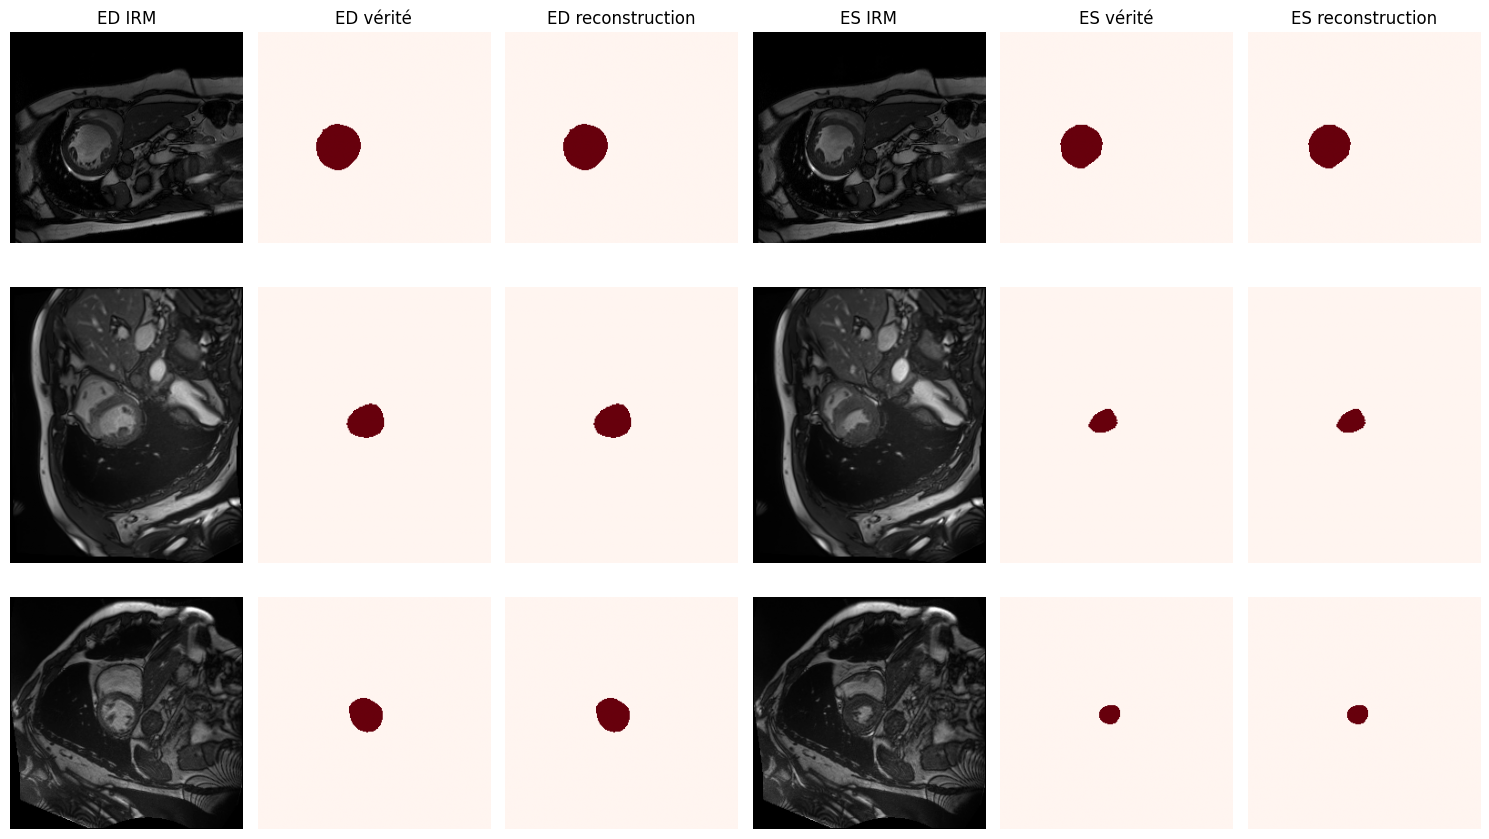

In [29]:
sample_ids = random.sample(subject_ids, 3)
phases = ["ED", "ES"]

fig, axes = plt.subplots(len(sample_ids), 6, figsize=(15, 9))
col_titles = ['ED IRM', 'ED vérité', 'ED reconstruction', 'ES IRM', 'ES vérité', 'ES reconstruction']
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title)

for i, sid in enumerate(sample_ids):
    for j, phase in enumerate(phases):
        img_path = os.path.join(data_dir, sid, f"{sid}_{phase}.nii")
        seg_path = os.path.join(data_dir, sid, f"{sid}_{phase}_seg.nii")
        if not os.path.exists(img_path) or not os.path.exists(seg_path):
            continue

        img_vol, _ = load_nifti(img_path)
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)

        seg_no3 = np.where(seg == 3, 0, seg)
        recon = segment_lv_from_myo(seg_no3)

        H, W, D = seg.shape
        slice_idx = D // 3

        axes[i, j*3 + 0].imshow(img_vol[:, :, slice_idx], cmap='gray')
        axes[i, j*3 + 1].imshow(seg[:, :, slice_idx] == 3, cmap='Reds')
        axes[i, j*3 + 2].imshow(recon[:, :, slice_idx] == 3, cmap='Reds')

        for k in range(3):
            axes[i, j*3 + k].axis('off')

        if j == 0:
            axes[i, 0].set_ylabel(f"Sujet {sid}", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# Dossiers d'entrée et sortie
train_dir = "data/Test"
test_dir = "data/Test2"
os.makedirs(test_dir, exist_ok=True)

def dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2.0 * intersection.sum() / (mask1.sum() + mask2.sum() + 1e-8)

# Liste des patients (dossiers)
subject_ids = sorted(os.listdir(train_dir))  # ["101", "102", ...]

for subject_id in tqdm(subject_ids):
    subject_train_path = os.path.join(train_dir, subject_id)
    if not os.path.isdir(subject_train_path):
        continue  # on saute les fichiers

    # Dossier de sortie
    subject_test_path = os.path.join(test_dir, subject_id)
    os.makedirs(subject_test_path, exist_ok=True)

    for phase in ["ED", "ES"]:
        # Fichiers image et segmentation
        img_path = os.path.join(subject_train_path, f"{subject_id}_{phase}.nii")
        seg_path = os.path.join(subject_train_path, f"{subject_id}_{phase}_seg.nii")

        if not os.path.exists(img_path) or not os.path.exists(seg_path):
            print(f"Fichiers manquants pour {subject_id} {phase}")
            continue

        # Charger image (pas modifiée)
        img_nii = nib.load(img_path)
        img_data = img_nii.get_fdata()

        # Charger segmentation et reconstruire le label 3
        seg_nii = nib.load(seg_path)
        seg_data = seg_nii.get_fdata().astype(np.uint8)  
        seg_with_lv = segment_lv_from_myo(seg_data)
        seg_with_lv = seg_with_lv.astype(np.uint8)      

        # Sauvegarde image et segmentation reconstruite
        nib.save(nib.Nifti1Image(img_data, img_nii.affine), os.path.join(subject_test_path, f"{subject_id}_{phase}.nii"))
        nib.save(nib.Nifti1Image(seg_with_lv, seg_nii.affine), os.path.join(subject_test_path, f"{subject_id}_{phase}_seg.nii"))


100%|██████████| 51/51 [00:02<00:00, 19.48it/s]
